# Loading Hyperbolic Orbits into REBOUND

Imagine we have a table of orbital elements for comets (kindly provided by Toni Engelhardt).

In [9]:
from io import StringIO
import numpy as np
import rebound
epoch_of_elements = 53371.0 # [MJD, days]
c = StringIO(u"""
# id     e          q[AU]      i[deg]      Omega[deg]  argperi[deg]  t_peri[MJD, days]  epoch_of_observation[MJD, days]
168026   12.181214  15.346358  136.782470  37.581438   268.412314    54776.806093       55516.41727
21170    2.662235   2.013923   140.646538  23.029490   46.292039     54336.126288       53673.44043   
189298   15.503013  11.550314  20.042232   203.240743  150.855761    55761.641176       55718.447145 
72278    34.638392  24.742323  157.984412  126.431540  178.612758    54382.158401       54347.240445
109766   8.832472   9.900228   144.857801  243.102255  271.345342    55627.501618       54748.37722
""")
comets = np.loadtxt(c) # load the table into a numpy array

We  want to add these comits to a REBOUND simulation(s).  The first thing to do is set the units, which have to be consistent throughout.  Here we have a table in AU and days, so we'll use the gaussian gravitational constant (AU, days, solar masses).  

In [10]:
sim = rebound.Simulation()
k = 0.01720209895 # Gaussian constant
sim.G = k**2

We also set the simulation time to the epoch at which the elements are valid:

In [11]:
sim.t = epoch_of_elements

We then add the giant planets in our Solar System to the simulation.  You could for example query JPL HORIZONS for the states of the planets at each comet's corresponding epoch of observation (see [Horizons.ipynb](Horizons.ipynb)).  Here we set up toy masses and orbits for Jupiter & Saturn:

In [12]:
sim.add(m=1.) # Sun
sim.add(m=1.e-3, a=5.) # Jupiter
sim.add(m=3.e-4, a=10.) # Saturn

Let's write a function that takes a comet from the table and adds it to our simulation:

In [13]:
def addOrbit(sim, comet_elem):
    tracklet_id, e, q, inc, Omega, argperi, t_peri, epoch_of_observation = comet_elem
    sim.add(primary=sim.particles[0], 
            a = q/(1.-e),
            e = e,
            inc = inc*np.pi/180.,  # have to convert to radians
            Omega = Omega*np.pi/180.,
            omega = argperi*np.pi/180.,
            T = t_peri  # time of pericenter passage
           )

By default, REBOUND adds and outputs particles in Jacobi orbital elements.  Typically orbital elements for comets are heliocentric.  Mixing the two will give you relative errors in elements, positions etc. of order the mass ratio of Jupiter to the Sun ($\sim 0.001$) which is why we pass the additional `primary=sim.particles[0]` argument to the `add()` function.  If this level of accuracy doesn't matters to you, you can ignore the `primary` argument.



We can now set up the first comet and quickly plot to see what the system looks like:

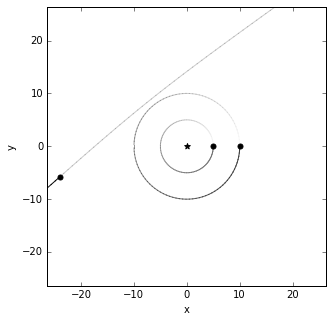

In [14]:
addOrbit(sim, comets[0])
%matplotlib inline
fig = rebound.OrbitPlot(sim, trails=True)

Now we just integrate until whatever final time we’re interested in.  Here it's the epoch at which we observe the comet, which is the last column in our table:

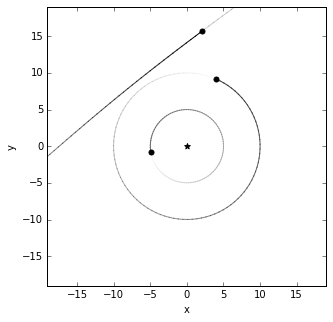

In [15]:
tfinal = comets[0][-1]
sim.integrate(tfinal)
fig = rebound.OrbitPlot(sim, trails=True)

REBOUND automatically find out if you want to integrate forward or backward in time.

For fun, let's add all the coments to a simulation:

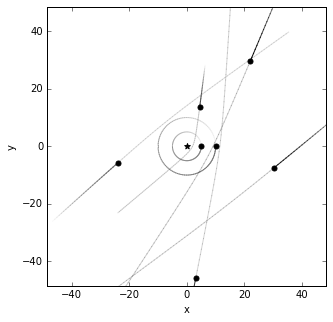

In [16]:
sim = rebound.Simulation()
sim.G = k**2
sim.t = epoch_of_elements 
sim.add(m=1.) # Sun
sim.add(m=1.e-3, a=5.) # Jupiter
sim.add(m=3.e-4, a=10.) # Saturn
for comet in comets:
    addOrbit(sim, comet)
fig = rebound.OrbitPlot(sim, trails=True)